In [12]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../../")

import numpy as np

%matplotlib widget

In [13]:
from src.utils.custom_gates import ConversionGainGate
from src.utils.polytope_wrap import monodromy_range_from_target, coverage_to_haar_expectation
from src.basis import CircuitTemplate, MixedOrderBasisCircuitTemplate
from src.utils.visualize import unitary_to_weyl, unitary_2dlist_weyl, coordinate_2dlist_weyl
from src.utils.custom_gates import CustomCostGate
from qiskit.circuit.library import CXGate, SwapGate
from weylchamber import c1c2c3
from src.utils.snail_death_gate import SpeedLimitedGate
from tqdm import tqdm
import matplotlib.pyplot as plt

In [14]:
# # verifying that relative phase doesn't change 2Q gate location
# unitary = [ConversionGainGate(0, 0, p*0.5*np.pi, (1-p)*0.4*np.pi) for p in np.linspace(0,1,16)]
# print([u.cost() for u in unitary])
# unitary_to_weyl(*unitary);

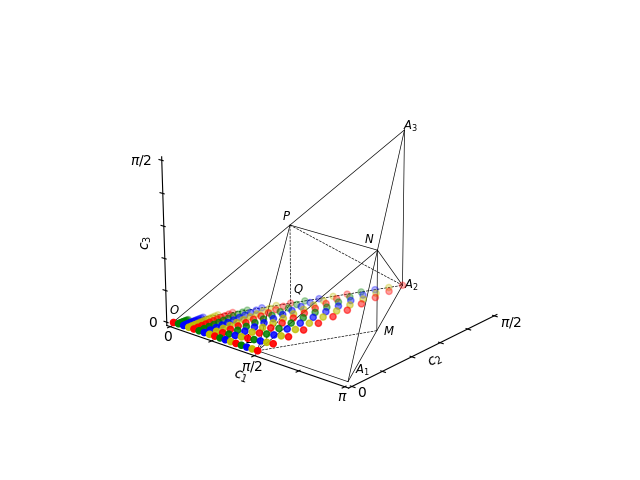

In [67]:
#plotting to make sure getting good weyl coverage before running data collection
"""Here we are building the set of gates to collect data over
The math here is translating gates to left side of x-axis to remove duplicates"""

unitary_list = []
coordinate_list = []
for k in np.linspace(0, 0.5, 17):
    inner_list = []
    for p in np.linspace(0, 1, 21):
        gate = ConversionGainGate(0, 0, p*k*np.pi, (1-p)*k*np.pi)
        unitary= gate.to_matrix()
        c = list(c1c2c3(np.array(unitary)))
        if c[0] > 0.5:
            c[0] = -1*c[0] + 1
        
        if c in inner_list or any(c in inner for inner in coordinate_list):
            continue

        inner_list.append(c)
        unitary_list.append(gate)
    
    #

    coordinate_list.append(inner_list)
coordinate_2dlist_weyl(*coordinate_list);

In [68]:
len(unitary_list)

177

In [17]:
# template = MixedOrderBasisCircuitTemplate(base_gates=[CustomCostGate(CXGate(), "CX")], chatty_build=1)
# coverage_to_haar_expectation(template.coverage, chatty=1)

First minor problem I am facing is that when counting 1Q gates, I am adding a 1/10 iswap duration for each layer of 1Q gates. This adds a 1Q layer following each 2Q layer; but there should actually be 1 additional layer of 1Q not being counted. (think if we have a single 2Q layer then there are two 1Q layers because one on each side). To fix this would be kind of complicated so I am using the approximation for now.

I can fix this for the cnot and swap score calcs by offsetting by a single 1Q layer but I can't figure out how to do this for the haar score calculation because the polytope costs are created in a strange way. For now I will ignore the offset on cnot and swap scores for consistency.

Second, assumes between each 2Q layer is a 1Q layer (but for some decomps they could go away) for example SWAP out of CNOTs requires 3 CNOTs and 0 1Q gates. I think this is a fine approximation still.


If I had better control over polytope costs, I feel like I should only need to compute the coverage sets once, and then be able to apply a shifting 1Q cost - but for now I can't figure out how to do that - which means I have to recompute the expensive set of data over again!

I think I could fix these both problems. What I need to do is to treat each gate with a constant cost = 1, that way the coverage cost is only representing the number of repetitions. Then later I can scale by cost of the 2Q gate, and add cost of 1Q gates easily too. This fixes the problem of 1Q gates as well as not needing to recompute the entire data sets when wanting to change the costs of the gate!

In [40]:
import h5py
filename = '/home/evm9/decomposition_EM/data/cg_gates.h5'

def collect_data(overwrite=False):
    """Using bare costs in mixedorderbasis template - this means the costs are in terms of number of gates
    means we need to scale by costs later - but don't have to recompute each time :)"""
    with h5py.File(filename, 'a') as hf:
        g = hf.require_group('bare_cost')
        if overwrite:
            g.clear()
        for base_gate in tqdm(unitary_list[1:]): #skip the identity gate - can't build valid coverage from it
            if str(base_gate) in g:
                #print("already have this gate")
                continue
            template = MixedOrderBasisCircuitTemplate(base_gates=[base_gate], chatty_build=0, bare_cost=True)
            haar_score = coverage_to_haar_expectation(template.coverage, chatty=0)
            cnot_score = monodromy_range_from_target(template, target_u = CXGate().to_matrix())[0] 
            swap_score = monodromy_range_from_target(template, target_u = SwapGate().to_matrix())[0]
            #print(haar_score, cnot_score, swap_score)
            #FIXME adding a None to end of score list makes so not a jagged 2d array - can fix better later
            #XXX is a problem if changing size of base_gate.params
            g.create_dataset(str(base_gate), data=np.array([base_gate.params, [haar_score, cnot_score, swap_score, -1, -1]]))

def get_group_name(speed_method='linear', duration_1q=0):
    return f'{speed_method}_scaling_1q{duration_1q}'

def cost_scaling(speed_method='linear', duration_1q=0):
    """Use bare costs to add in costs of 2Q gate and 1Q gates"""
    group_name = get_group_name(speed_method, duration_1q)
    with h5py.File(filename, 'a') as hf:
        g = hf.require_group('bare_cost')
        g2 = hf.require_group(group_name)
        for v in g.values():
            params = v[0]
            scores = np.array(v[1])

            #reconstruct gate object to get cost
            if 'dynamic' in speed_method:
                gate = SpeedLimitedGate(*params)
            else:
                gate = ConversionGainGate(*params)

            if str(gate) in g2:
                #print("already have this gate")
                continue
            
            #compute scaled costs
            scaled_scores = scores * gate.cost() #scale by 2Q gate cost
            scaled_scores += (scores + 1) * duration_1q #scale by 1Q gate cost

            #store
            g2.create_dataset(str(gate), data=[gate.params, scaled_scores])

In [19]:
def plot_eharr(group_name):
    with h5py.File(filename, 'r') as hf:
        g = hf.require_group(group_name)
        x,y, z = [], [], []
        for v in g.values():
            params = v[0]
            scores = np.array(v[1])
            x.append(params[2]) #gain
            y.append(params[3]) #conv
            z.append(scores[0]) #change this to 0 or 1 or 2 for haar or cnot or swap

        #plot E[harr] vs gain and conv
        plt.close()    
        plt.figure()
        plt.scatter(x, y, s=100, c=z)
        plt.ylabel("gain")
        plt.xlabel('conv')
        cbar = plt.colorbar()
        cbar.set_label("E[haar]", rotation=90)

In [49]:
def pick_winner(group_name):
    with h5py.File(filename, 'r') as hf:
        g = hf.require_group(group_name)
        z = []
        for v in g.values():
            scores = np.array(v[1])
            z.append(scores[0]) #change this to 0 or 1 or 2 for haar or cnot or swap

        winner = list(g.values())[np.argmin(z)] #XXX not sure if works
        winner_gate = ConversionGainGate(*winner[0])
        print(winner[0]) #params
        print(winner[1]) #scores
        print(winner_gate.cost()) #cost

        unitary_to_weyl(winner_gate.to_matrix()); #uncomment to see the gate in weyl space
        return winner   

In [36]:
collect_data()

100%|██████████| 88/88 [00:00<00:00, 17399.65it/s]


[0.         0.         0.         0.19634954 1.        ]
[ 0.9114924  1.         1.5       -0.125     -0.125    ]
0.125


<Closed HDF5 dataset>

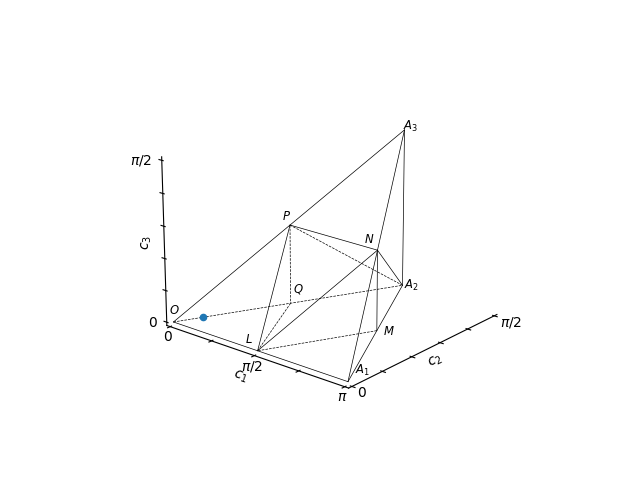

In [52]:
method = 'linear'
duration_1q = 0
group_name = get_group_name(method, duration_1q)
cost_scaling(speed_method=method, duration_1q=duration_1q)
plot_eharr(group_name)
pick_winner(group_name)

[0.         0.         0.00981748 0.18653206 1.        ]
[ 0.85865836  0.92906977  1.50973837 -0.11613372 -0.11613372]
0.125


<Closed HDF5 dataset>

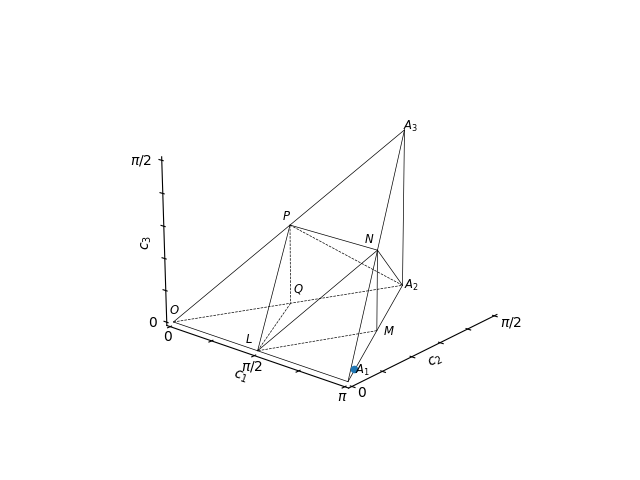

In [58]:
method = 'dynamic'
duration_1q = 0
group_name = get_group_name(method, duration_1q)
cost_scaling(speed_method=method, duration_1q=duration_1q)
plot_eharr(group_name)
pick_winner(group_name)

[0.         0.         0.03926991 0.74612826 1.        ]
[ 1.38192297  1.3         2.5        -0.5        -0.5       ]
0.5


<Closed HDF5 dataset>

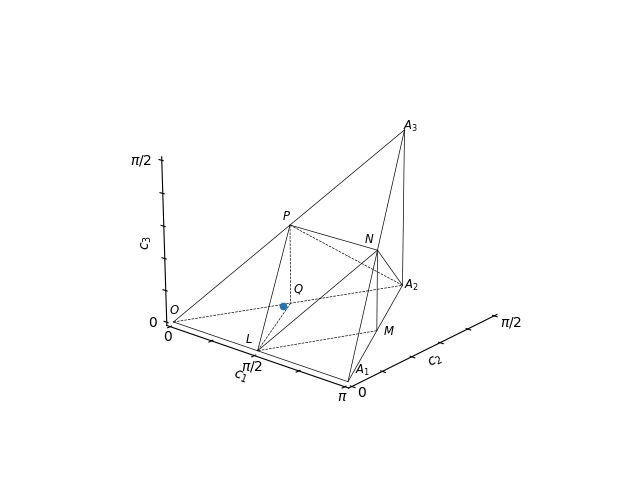

In [61]:
method = 'linear'
duration_1q = 0.1
group_name = get_group_name(method, duration_1q)
cost_scaling(speed_method=method, duration_1q=duration_1q)
plot_eharr(group_name)
pick_winner(group_name)

[0.         0.         0.03926991 0.74612826 1.        ]
[ 1.30615039  1.22906977  2.35813953 -0.46453488 -0.46453488]
0.5


<Closed HDF5 dataset>

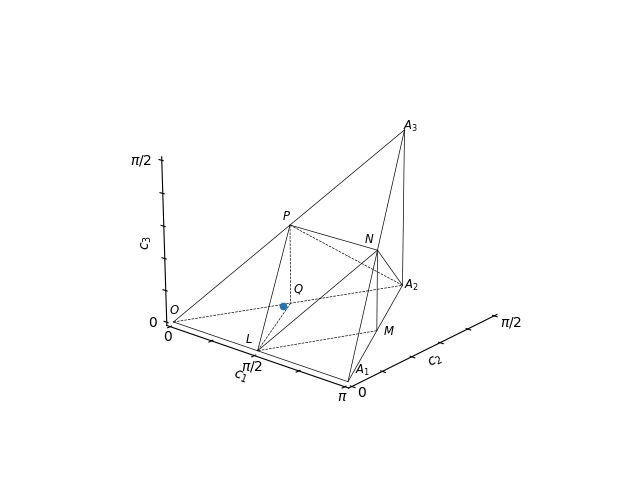

In [60]:
method = 'dynamic'
duration_1q = 0.1
group_name = get_group_name(method, duration_1q)
cost_scaling(speed_method=method, duration_1q=duration_1q)
plot_eharr(group_name)
pick_winner(group_name)

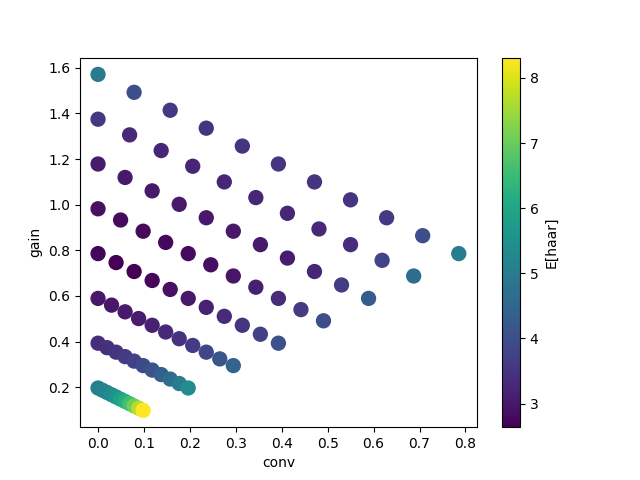

In [64]:
method = 'linear'
duration_1q = 0.5
group_name = get_group_name(method, duration_1q)
cost_scaling(speed_method=method, duration_1q=duration_1q)
plot_eharr(group_name)
# pick_winner(group_name)

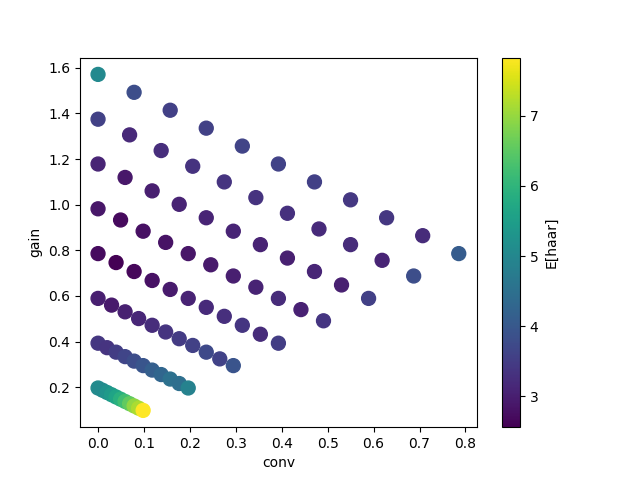

In [65]:
method = 'dynamic'
duration_1q = 0.5
group_name = get_group_name(method, duration_1q)
cost_scaling(speed_method=method, duration_1q=duration_1q)
plot_eharr(group_name)
# pick_winner(group_name)